# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from DSVC.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'DSVC/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


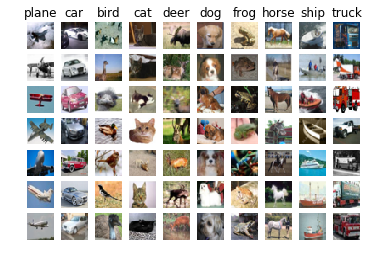

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


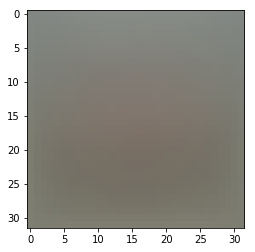

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


### 间隔与支持向量

在样本空间当中，划分超平面可通过如下线性方程来描述： $\pmb{w}^{T}\pmb{x} + b = 0$

其中$\pmb{w} = (w_1;w_2;...;w_d)$为法向量，决定了超平面的方向；b为位移项，决定了超平面与原点之间的距离。

样本空间中任意点$x$到超平面$(\pmb{w},b)$距离可写为

$$r = \frac{\left| \pmb{w}^{T}\pmb{x} + b \right|}{\left|\left| \pmb{w} \right|\right|}$$

假设超平面可以将训练样本正确分类，则对于$(\pmb{x}_i,y_i) \in D$，

若$y_i= +1$,则有$\pmb{w}^{T}\pmb{x_i} + b > 0$;

若$y_i= -1$,则有$\pmb{w}^{T}\pmb{x_i} + b < 0$.

令:

$$\begin{align} &\begin{cases} \pmb{w}^{T}\pmb{x} + b \ge +1,y_i = +1 \\ \pmb{w}^{T}\pmb{x} + b \le -1,y_i = -1 \end{cases} \end{align}$$

![支持向量机](https://upload-images.jianshu.io/upload_images/9140378-9d0cec81162dc653.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

距离超平面的几个训练样本点使得上述的等号成立，他们就被称作"支持向量"。

两个异类到超平面的距离之和为： $\gamma = \frac{2}{||\pmb{w}||}$

想要找到"最大间隔的"的划分超平面，就是要找到满足上式约束的参数$\pmb{w}$和$b$,使得$\gamma$最大

即：

$$\normalsize{max_{\pmb{w},b} \frac{2}{||\pmb{w}||}}$$
$$\normalsize{s.t. y_i(\pmb{w}^{T}\pmb{x} + b) \ge 1,i = 1,2,3...,m.}$$

由于最大化$\frac{1}{||\pmb{w}||}$等价于最小化$||\pmb{w}||^2$,上式可继续写为：

$$\normalsize{min_{\pmb{w},b} \frac12 ||\pmb{w}||^2}$$
$$\normalsize{s.t.   y_i(\pmb{w}^{T}\pmb{x} + b) \ge 1,i = 1,2,3...,m.}$$

### 对偶问题

我们希望通过求解上式来得到最大化分超平面所对应的模型

$f(x) = \pmb{w}^{T}\pmb{x} + b$,其中$\pmb{w}$和$b$是模型参数。

对于该式本身是一个凸二次规划问题，我们使用拉格朗日乘子法可得到其“对偶问题”，该问题的拉格朗日函数可写为：

$$L(w, b, \alpha)=\frac{1}{2}\|w\|^{2}+\sum_{i=1}^{N} \alpha_{i}\left(1-y_{i}\left(w \cdot x_{i}+b\right)\right)$$

其中，$\alpha=\left(\alpha_{1} ; \alpha_{2} ; ... ; \alpha_{m}\right)$ ，令$L(w,b,\alpha)$对$w$和$b$的偏导为零可得：

$$\begin{array}{c}{\nabla_{w} L(w, b, \alpha)=w-\sum_{i=1}^{N} \alpha_{i} x_{i} y_{i}=0} \\ {\nabla_{b} L(w, b, \alpha)=\sum_{i=1}^{N} \alpha_{i} y_{i}=0}\end{array}$$

即：

$$\begin{array}{c}{w=\sum_{i=1}^{N} \alpha_{i} y_{i} x_{i}^T} \\ {0=\sum_{i=1}^{N} \alpha_{i} y_{i}}\end{array}$$

带入到原函数当中，消去$w$和$b$后可得：

$$L(w, b, \alpha)=\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} x_{i} x_{j}+\sum_{i=1}^{N} \alpha_{i}\left(1-y_{i}\left(x_{i} \sum_{j=1}^{N} \alpha_{j} y_{j} x_{j}+b\right)\right)$$

$$=\sum_{i=1}^{N} \alpha_{i} -\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} x_{i} x_{j}$$

于是得到对偶问题：

$$max_{\alpha} \sum_{i=1}^{N} \alpha_{i} -\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} x_{i} x_{j} $$

$$s.t.   \quad \sum_{i=1}^{N} \alpha_{i} y_{i}=0, \quad \alpha_{i} \geq 0, \quad i=1,2, \cdots, N$$

### 关于梯度矩阵dW的求法

```python
num_classes = W.shape[1]
num_train = X.shape[0]
loss = 0.0
for i in xrange(num_train):
    scores = X[i].dot(W)  # 计分函数
    correct_class_score = scores[y[i]]
    for j in xrange(num_classes):
        if j == y[i]:
            continue
        margin = scores[j] - correct_class_score + 1  # note delta = 1
        if margin > 0:
            loss += margin
            
# Right now the loss is a sum over all training examples, but we want it
# to be an average instead so we divide by num_train.
loss /= num_train

# Add regularization to the loss.
loss += reg * np.sum(W * W)
```

损失函数的计算公式为

$$L = \frac{1}{N}\sum_{i = 0}^{num\_train}\left( \sum_{j \not= y_i}^{num\_classes}{\left(max(0,f(x_i;\pmb{W})_j - f(x_i;\pmb{W})_{y_i} + \Delta \right)}\right) + \lambda \sum_{k}\sum_{l}W_{k,l}^{2}$$

其中函数$f$即为计分函数

score即为关于权重W的各个分类器的得分,计算方法为：

$$scores = f(x_i,W) = X[i] \cdot W$$


矩阵dW由各样本$x_i(i = 1,2...,N)$在点W的各个分类方向c(c = 1,2...C)上的损失函数的梯度构成。

即为各个样本在各个分类方向上的下降速度

$$\nabla_w L_{i,j} = \frac{\partial}{\partial w} L_i = \begin{cases} \frac{\partial}{\partial w_j} L_i ,(j \not= y_i) \\ \frac{\partial}{\partial w_{y_i}} L_i ,(j = y_i) \end{cases}$$

根据损失函数的公式：

$$L_i = \sum_{j \not= y_{i}}{\left[max(0,w_j^Tx_i - w_{y_i}^Tx_i + \triangle)\right]}$$

我们将$L_i$展开后可以得到其具体表达式为：

$$L_{i}=\max \left(0, x_{i 1} w_{11}+x_{i 2} w_{12} \ldots+x_{i D} w_{1 D}-x_{i 1} w_{y_{i} 1}-x_{i 2} w_{y_{i} 2} \ldots-x_{i D} w_{y_{i} D}+\Delta\right)+\max \left(0, x_{i 1} w_{21}+x_{i 2} w_{22} \dots+x_{i D} w_{2 D}-x_{i 1} w_{y_{i} 1}-x_{i 2} w_{y_{i} 2} \dots-x_{i D} w_{y_{i} D}+\Delta\right)+ \\ ...\\ ...\\ \max \left(0, x_{i 1} w_{C 1}+x_{i 2} w_{C 2} \dots+x_{i D} w_{C D}-x_{i 1} w_{y_{i} 1}-x_{i 2} w_{y_{i} 2} \ldots-x_{i D} w_{y_{i} D}+\Delta\right)$$

先忽略max(0,...)函数（即将小于0位置导数置0即可）,得到其求导值：

$$\nabla_{\boldsymbol{w}} \boldsymbol{L}_{\boldsymbol{i}}=\left[\begin{array}{llll}{\frac{d L_{i}}{d w_{1}}} & {\frac{d L_{i}}{d w_{2}}} & {\cdots} & {\frac{d L_{i}}{d w_{C}}}\end{array}\right] = \left[\begin{matrix}\frac{dL_i}{dw_{11}} & \frac{dL_i}{dw_{21}} & ... \frac{dL_i}{dw_{y_i1}}& ... & \frac{dL_i}{dw_{C1}} \cr ... & ... & ... & ... & ... \cr ... & ... & ... & ... & ... \cr \frac{dL_i}{dw_{1D}} & \frac{dL_i}{dw_{2D}} & ... \frac{dL_i}{dw_{y_iD}}& ... & \frac{dL_i}{dw_{CD}} \end{matrix}\right] = \left[\begin{matrix}x_{i1} & x_{i1} & ...  -x_{i1} & ... & -x_{iD} \cr ... & ... & ... & ... & ... \cr ... & ... & ... & ... & ... \cr x_{iD} & x_{iD} & ... -x_{i1}& ... & -x_{iD} \end{matrix}\right]$$

也就是得到：

$$\frac{dL_i}{dw_j} = 1 {(w_j^Tx_i - w_{y_i}^Tx_i + \triangle > 0)} \cdot \left[\begin{matrix}x_{i1} \cr x_{i2} \cr \dots \cr \dots \cr x_{iD}\end{matrix}\right] = 1 {(w_j^Tx_i - w_{y_i}^Tx_i + \triangle > 0)} \cdot x_i$$

$$\frac{dL_i}{dw_{y_i}} = - \sum_{j \not= y_i}{1(w_j^Tx_i - w_{y_i}^Tx_i + \triangle > 0)} \cdot \left[\begin{matrix}x_{i1} \cr x_{i2} \cr \dots \cr \dots \cr x_{iD}\end{matrix}\right] = - \sum_{j \not= y_i} 1{(w_j^Tx_i - w_{y_i}^Tx_i + \triangle > 0)} \cdot x_i$$

最终，取得dW(i,j)的值为：

- -n$X_i$，n取决于有多少个界值大于0.可以利用计算loss中的循环。
- $X_i$ 当$j\not=y_i$时。 

## SVM Classifier

Your code for this section will all be written inside **DSVC/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from DSVC.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.791360


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from DSVC.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -9.703256 analytic: -9.703256, relative error: 2.179481e-11
numerical: -9.135158 analytic: -9.135158, relative error: 3.311239e-12
numerical: -1.702428 analytic: -1.702428, relative error: 6.340181e-12
numerical: 26.921887 analytic: 26.921887, relative error: 6.684031e-12
numerical: -0.027006 analytic: -0.027006, relative error: 7.005363e-09
numerical: -14.564484 analytic: -14.564484, relative error: 7.135378e-12
numerical: 0.153915 analytic: 0.153915, relative error: 4.475362e-12
numerical: 16.225296 analytic: 16.225296, relative error: 1.686605e-11
numerical: -31.296946 analytic: -31.296946, relative error: 4.148340e-12
numerical: -21.663849 analytic: -21.663849, relative error: 7.396974e-12
numerical: 37.512007 analytic: 37.512007, relative error: 1.107050e-11
numerical: -42.646720 analytic: -42.646720, relative error: 3.983177e-12
numerical: -5.843969 analytic: -5.843969, relative error: 6.538579e-11
numerical: 1.742762 analytic: 1.742762, relative error: 2.134645e-10
nu

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from DSVC.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.791360e+00 computed in 0.129655s
Vectorized loss: 8.791360e+00 computed in 0.003993s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.139627s
Vectorized loss and gradient: computed in 0.002990s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from DSVC.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

That took 8.185114s


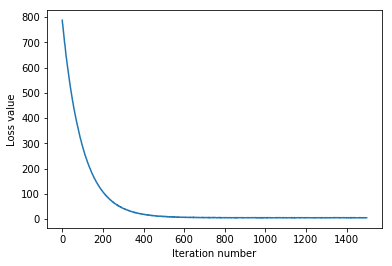

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369694
validation accuracy: 0.378000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8,3e-8,51e-8,7e-8,1e-7,2e-7,3e-7]
regularization_strengths = [1e4,2e4,3e4,4e4,5e4,6e4,7e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

num_iters_i = 1500
val_accuracy_history = []
for lr_i in learning_rates:
    for reg_i in regularization_strengths:
        lin_svm = LinearSVM()
        loss_history_i = lin_svm.train(X_train, y_train, lr_i,reg_i,num_iters_i, verbose=True)
        
        y_train_pred_i = lin_svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred_i)
        
        y_val_pred_i = lin_svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred_i)
        
        results[(lr_i,reg_i)] = (train_accuracy,val_accuracy)
        val_accuracy_history.append(val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = lin_svm
    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.231306 val accuracy: 0.262000
lr 1.000000e-08 reg 2.000000e+04 train accuracy: 0.237857 val accuracy: 0.264000
lr 1.000000e-08 reg 3.000000e+04 train accuracy: 0.260816 val accuracy: 0.261000
lr 1.000000e-08 reg 4.000000e+04 train accuracy: 0.278510 val accuracy: 0.291000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.297388 val accuracy: 0.305000
lr 1.000000e-08 reg 6.000000e+04 train accuracy: 0.314612 val accuracy: 0.351000
lr 1.000000e-08 reg 7.000000e+04 train accuracy: 0.329796 val accuracy: 0.331000
lr 3.000000e-08 reg 1.000000e+04 train accuracy: 0.307245 val accuracy: 0.302000
lr 3.000000e-08 reg 2.000000e+04 train accuracy: 0.353143 val accuracy: 0.363000
lr 3.000000e-08 reg 3.000000e+04 train accuracy: 0.366776 val accuracy: 0.378000
lr 3.000000e-08 reg 4.000000e+04 train accuracy: 0.364184 val accuracy: 0.377000
lr 3.000000e-08 reg 5.000000e+04 train accuracy: 0.361327 val accuracy: 0.376000
lr 3.000000e-08 reg 6.000000

Text(0.5,1,'CIFAR-10 training accuracy')

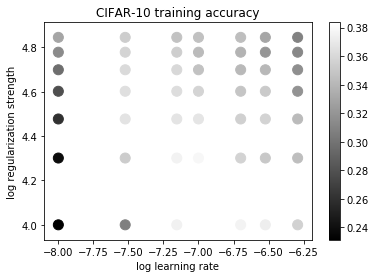

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

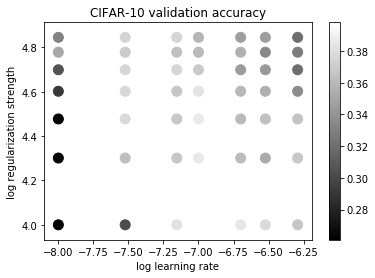

In [18]:
# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.375000


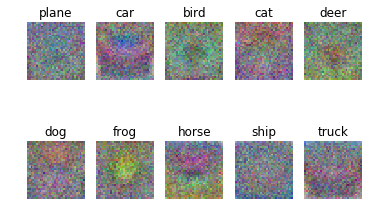

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *就是每个模型叠加起来的图像*